In [1]:
!pip install torch torchvision transformers opencv-python scikit-learn thop

In [2]:
import pandas as pd

# Load the CSV file
url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vTyh006zrmSWoKAwqF92kZ4lvNRKsZL5NYIkdSEK3wtrWA8yMKLT6K3h1k1nyyHjG9ntZvc9tTcbUif/pub?output=csv'
df = pd.read_csv(url,encoding="utf-8")
df.head()


,id,caption,label,level,area,Unnamed: 5
0,1,গোমতী নদীর পানি উত্তর পাশে পালপাড়া অংশে বাঁধ থ...,flood,1.0,NaN,NaN
1,2,গোমতী নদীর পানি উত্তর পাশে পালপাড়া অংশে বাঁধ থ...,flood,1.0,NaN,NaN
2,3,কুমিল্লা,flood,1.0,কুমিল্লা,NaN
3,4,আখাউড়া উপজেলা ও কসবা উপজেলা'র বিভিন্ন এলাকায় ই...,flood,1.0,আখাউড়া,NaN
4,5,ফেনীর মুহুরী নদীতে পানির মাত্রা গত ৪০ বছরের ইত...,flood,1.0,ফেনী,NaN


In [3]:
# Verify column names
print(df.columns)

Index([' id', 'caption', 'label', 'level', 'area', 'Unnamed: 5'], dtype='object')


In [4]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup, BertModel
from torchvision import transforms, models
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np
from thop import profile

In [5]:
# Drop unnecessary columns if they exist
columns_to_drop = [col for col in ['level', 'area', 'Unnamed: 5'] if col in df.columns]
df = df.drop(columns_to_drop, axis=1)

# Shuffle the dataframe
df = shuffle(df, random_state=42)

In [6]:
df.head()

,id,caption,label
1057,1058,পাইলটের শেষ মুহূর্তের প্রচেষ্টা সত্ত্বেও দুর্ঘ...,Anthropogenic
5868,5869,প্যাডেল এক্সারসাইজার মিনি এক্সারসাইজ বাইক আর্ম...,Non Informative
4195,4196,দেশাল ব্লাউজ কালেকশনে প্রতিটি ব্লাউজে রয়েছে হা...,Non Informative
4837,4838,খিচুড়ি - হাস ভুনা - আমের আচার 🌻🌻,Non Informative
4354,4355,কালকে ওরে সোফার রুমে ঘুমে রেখে এসে আমি বেডরুমে...,Non Informative


In [7]:
# Define label mapping
label_mapping = {
    'flood': 0,
    'Cyclone': 1,
    'Earthquake': 2,
    'River Erosion': 3,
    'Fire' : 4,
    'Anthropogenic': 5,
    'Non Informative': -1  # Will be filtered out
}

# Apply label mapping and remove 'Non Informative' rows
df['label'] = df['label'].map(label_mapping)
df = df[df['label'] != -1].reset_index(drop=True)

In [8]:
import random

# Random Deletion
def random_deletion_bn(text, p=0.1):
    words = text.split()
    if len(words) == 1:
        return text
    remaining = [w for w in words if random.uniform(0,1) > p]
    if not remaining:
        return random.choice(words)
    return ' '.join(remaining)

# Random Swap
def random_swap_bn(text, n=1):
    words = text.split()
    length = len(words)
    if length < 2:
        return text
    for _ in range(n):
        idx1, idx2 = random.sample(range(length), 2)
        words[idx1], words[idx2] = words[idx2], words[idx1]
    return ' '.join(words)

# Character-level Noise
def char_noise_bn(text, p=0.03):
    noisy_text = ''
    for c in text:
        if random.uniform(0,1) < p and c != ' ':
            noisy_text += random.choice('অআইঈউঊঋএঐওঔকখগঘচছজঝটঠডঢতথদধনপফবভমযরলশষসহ')
        else:
            noisy_text += c
    return noisy_text

# Combine all augmentations
def augment_bengali_text(text):
    # Step 1: Random Deletion
    text = random_deletion_bn(text, p=0.1)
    # Step 2: Random Swap
    text = random_swap_bn(text, n=1)
    # Step 3: Character-level noise
    text = char_noise_bn(text, p=0.03)
    return text

# Apply augmentation to your dataset
df['caption_aug'] = df['caption'].apply(augment_bengali_text)

print(df[['caption', 'caption_aug']].head(10)) 

                                             caption  \
0  পাইলটের শেষ মুহূর্তের প্রচেষ্টা সত্ত্বেও দুর্ঘ...   
1          বিকট শব্দে সিলিন্ডারবোঝাই ট্রাকে বিস্ফোরণ   
2  গোপালগঞ্জে একটি ভবনে আগুন, দমকল বাহিনী দ্রুত ব...   
3  মাদাগাস্কারের রেইনফরেস্টে বন উজাড়ের কারণে লেমু...   
4  বন্যায় ভীষণভাবে ক্ষতিগ্রস্ত হয়েছে স্পেনের ভ্যা...   
5  বাংলাদেশে গ্রামাঞ্চলে টিকা গ্রহণের হার কম, সংক...   
6  অনেকের বাড়ি আর ফিরে পাওয়া যাবে না… পথ এখন অনিশ...   
7          দুশ্চিন্তায় কেটে যায় অনেক সময়, নদীতে ভাঙন   
8  ঘূর্ণিঝড় ইয়াসে লন্ডভন্ড সেন্ট মার্টিনের পর্যট...   
9        প্রবল ঘূর্ণিঝড় থেকে স্থল নিম্নচাপ 'বুলবুল'   

                                         caption_aug  
0  শেষ মুহূর্তের দুর্ঘটনা সত্ত্বেও প্রচেষ্টা এড়ান...  
1          আিকট খিলিন্ডারবোঝাই শব্দে ট্রাকে বিস্ফোরণ  
2  গোপালগঞ্জে একটি হবনে আগুন, দমকল বাহিনী দ্রুত ব...  
3  মাদাগাস্কারের বন রএইনফরঠস্টে কারণে লেমুর প্রজা...  
4   প্রদেশ ভীষণভাবে ক্ষতিগ্রস্ত হয়েছে স্পেনের বন্যাত  
5             গ্রামাঞঝচলে টিকা ঝুঊকি হার কম, গ্রহণের 

In [9]:
# Split the dataset
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2

train_data, val_test = train_test_split(df, train_size=train_ratio, random_state=42)
valid_data, test_data = train_test_split(val_test, train_size=val_ratio / (val_ratio + test_ratio), random_state=42)

In [10]:
train_data.columns = train_data.columns.str.strip()
valid_data.columns = valid_data.columns.str.strip()
test_data.columns = test_data.columns.str.strip()


In [11]:
# Define image transformations
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

valid_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')



tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [12]:
# Custom Dataset
class MultimodalDataset(Dataset):
    def __init__(self, dataframe, images_folder, tokenizer, image_transforms):
        self.dataframe = dataframe
        self.images_folder = images_folder
        self.tokenizer = tokenizer
        self.image_transforms = image_transforms
        self.class_to_index = {
            'flood': 0,
            'cyclone': 1,
            'earthquake': 2,
            'river erosion': 3,
            'Fire' : 4,
            'anthropogenic': 5
        }
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        text = str(row['caption'])
        label = int(row['label'])
        image_id = str(row['id']).strip()

        image_path = os.path.join(self.images_folder, f"{image_id}.jpg")
        if not os.path.exists(image_path):
            image_path = os.path.join(self.images_folder, f"{image_id}.png")
        if not os.path.exists(image_path):
            image_path = os.path.join(self.images_folder, f"{image_id}.jpeg")
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Image {image_id} not found")

        image = Image.open(image_path).convert('RGB')
        image = self.image_transforms(image)
        text_inputs = self.tokenizer(text, return_tensors='pt', padding='max_length', truncation=True, max_length=128)

        assert 0 <= label <= 5, f"Label {label} out of range"

        return {
            'input_ids': text_inputs['input_ids'].squeeze(),
            'attention_mask': text_inputs['attention_mask'].squeeze(),
            'image': image,
            'label': torch.tensor(label, dtype=torch.long),
            'original_label': self.index_to_class[label]
        }

In [13]:
# Define image folder path
images_folder = "/kaggle/input/mddb-images/Photos_Final" 

# Datasets
train_dataset = MultimodalDataset(train_data, images_folder, tokenizer, train_transforms)
valid_dataset = MultimodalDataset(valid_data, images_folder, tokenizer, valid_test_transforms)
test_dataset  = MultimodalDataset(test_data,  images_folder, tokenizer, valid_test_transforms)

# Dataloaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=2)

In [14]:

print(len(train_dataset))
print(len(valid_dataset))
print(len(test_dataset))

1899
633
634


In [15]:
from transformers import ViTModel

class MultimodalModel(nn.Module):
    def __init__(self, text_model_name='bert-base-multilingual-cased', num_labels=6):
        super(MultimodalModel, self).__init__()
        
        # Text model remains the same
        self.text_model = BertModel.from_pretrained(text_model_name)
        
        # Change image model to Vision Transformer (ViT)
        self.image_model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        
        # Image model output embedding size is 768, so the classifier will take 768*2 inputs
        self.classifier = nn.Linear(768 * 2, num_labels)

    def forward(self, input_ids, attention_mask, image):
        # Forward pass for the text
        text_outputs = self.text_model(input_ids=input_ids, attention_mask=attention_mask)
        text_embeds = text_outputs.last_hidden_state[:, 0, :]  # Use [CLS] token embedding for text
        
        # Forward pass for the image
        image_outputs = self.image_model(image)
        image_embeds = image_outputs.pooler_output  # Use the pooled output from ViT
        
        # Concatenate both embeddings
        combined_embeds = torch.cat((text_embeds, image_embeds), dim=1)
        
        # Final classification layer
        logits = self.classifier(combined_embeds)
        return logits


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

[INFO] Register count_normalization() for <class 'torch.nn.modules.normalization.LayerNorm'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
Total Parameters: 171.89M
FLOPs: 443.93G


Epoch 1 [Val]: 100%|██████████| 40/40 [00:12<00:00,  3.15it/s]


Epoch 1, Train Loss: 1.3306, Train Acc: 0.5519, Val Loss: 0.7345, Val Acc: 0.8578


Epoch 2 [Val]: 100%|██████████| 40/40 [00:12<00:00,  3.13it/s]


Epoch 2, Train Loss: 0.6766, Train Acc: 0.8905, Val Loss: 0.6003, Val Acc: 0.9210


Epoch 3 [Val]: 100%|██████████| 40/40 [00:12<00:00,  3.08it/s]


Epoch 3, Train Loss: 0.5460, Train Acc: 0.9547, Val Loss: 0.5616, Val Acc: 0.9431


Epoch 4 [Val]: 100%|██████████| 40/40 [00:12<00:00,  3.16it/s]


Epoch 4, Train Loss: 0.4994, Train Acc: 0.9779, Val Loss: 0.5588, Val Acc: 0.9352


Epoch 5 [Val]: 100%|██████████| 40/40 [00:13<00:00,  3.08it/s]


Epoch 5, Train Loss: 0.4892, Train Acc: 0.9821, Val Loss: 0.5560, Val Acc: 0.9368


Epoch 6 [Val]: 100%|██████████| 40/40 [00:12<00:00,  3.13it/s]


Epoch 6, Train Loss: 0.4850, Train Acc: 0.9837, Val Loss: 0.5536, Val Acc: 0.9368


Epoch 7 [Val]: 100%|██████████| 40/40 [00:13<00:00,  3.04it/s]


Epoch 7, Train Loss: 0.4803, Train Acc: 0.9853, Val Loss: 0.5527, Val Acc: 0.9384


Epoch 8 [Val]: 100%|██████████| 40/40 [00:12<00:00,  3.13it/s]


Epoch 8, Train Loss: 0.4786, Train Acc: 0.9879, Val Loss: 0.5521, Val Acc: 0.9400


Epoch 9 [Val]: 100%|██████████| 40/40 [00:12<00:00,  3.08it/s]


Epoch 9, Train Loss: 0.4787, Train Acc: 0.9868, Val Loss: 0.5524, Val Acc: 0.9415


Epoch 10 [Val]: 100%|██████████| 40/40 [00:12<00:00,  3.15it/s]


Epoch 10, Train Loss: 0.4771, Train Acc: 0.9889, Val Loss: 0.5524, Val Acc: 0.9415


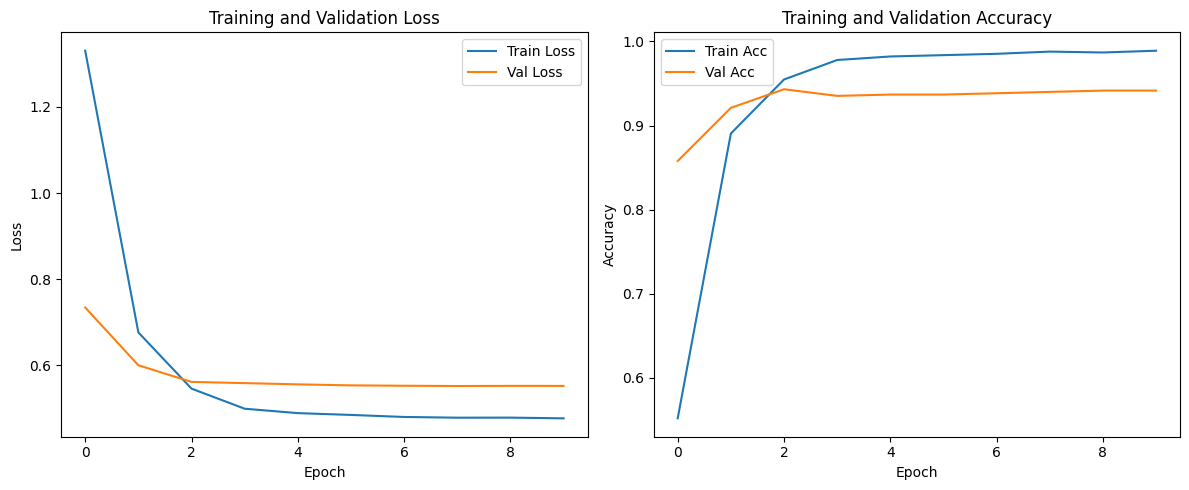

In [16]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultimodalModel(num_labels=6).to(device)

# Calculate parameters and FLOPs (optional)
sample_batch = next(iter(train_loader))
sample_input_ids = sample_batch['input_ids'].to(device)
sample_attention_mask = sample_batch['attention_mask'].to(device)
sample_image = sample_batch['image'].to(device)
flops, params = profile(model, inputs=(sample_input_ids, sample_attention_mask, sample_image))
print(f"Total Parameters: {params/1e6:.2f}M")
print(f"FLOPs: {flops/1e9:.2f}G")

# Optimizer, criterion, and scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

def train_model(model, train_loader, valid_loader, epochs=10, patience=3):
    best_val_loss = float('inf')
    patience_counter = 0

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        correct_train = 0
        total_train = 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            images = batch['image'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask, images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        avg_train_loss = total_train_loss / len(train_loader)
        train_acc = correct_train / total_train
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_acc)

        # Validation
        model.eval()
        total_val_loss = 0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for batch in tqdm(valid_loader, desc=f"Epoch {epoch+1} [Val]"):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                images = batch['image'].to(device)
                labels = batch['label'].to(device)

                outputs = model(input_ids, attention_mask, images)
                loss = criterion(outputs, labels)
                total_val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

        avg_val_loss = total_val_loss / len(valid_loader)
        val_acc = correct_val / total_val
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch + 1}, "
              f"Train Loss: {avg_train_loss:.4f}, "
              f"Train Acc: {train_acc:.4f}, "
              f"Val Loss: {avg_val_loss:.4f}, "
              f"Val Acc: {val_acc:.4f}")

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pt')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch + 1}")
                break

        scheduler.step()

    # Plot Loss and Accuracy
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Acc')
    plt.plot(val_accuracies, label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return train_losses, val_losses, train_accuracies, val_accuracies

# Train the model
train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_loader, valid_loader)


In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch

def evaluate_model(model, test_loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            images = batch['image'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids, attention_mask, images)
            _, preds = torch.max(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Convert indices to class names
    index_to_class = {0: 'flood', 1: 'cyclone', 2: 'earthquake', 3: 'river erosion', 4: 'fire', 5: 'anthropogenic'}
    all_labels = [index_to_class[label] for label in all_labels]
    all_preds = [index_to_class[pred] for pred in all_preds]

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1_weighted = f1_score(all_labels, all_preds, average='weighted')
    f1_macro = f1_score(all_labels, all_preds, average='macro')  # Macro F1 score
    report = classification_report(all_labels, all_preds)

    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test Precision (Weighted): {precision:.4f}")
    print(f"Test Recall (Weighted): {recall:.4f}")
    print(f"Test F1 Score (Weighted): {f1_weighted:.4f}")
    print(f"Test F1 Score (Macro): {f1_macro:.4f}")
    print("Classification Report:\n", report)

    # Confusion matrix
    labels = ['flood', 'cyclone', 'earthquake', 'river erosion','fire', 'anthropogenic']
    cm = confusion_matrix(all_labels, all_preds, labels=labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


<ipython-input-18-1c64671aff0c>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pt'))


Test Accuracy: 0.9432
Test Precision (Weighted): 0.9443
Test Recall (Weighted): 0.9432
Test F1 Score (Weighted): 0.9435
Test F1 Score (Macro): 0.9416
Classification Report:
                precision    recall  f1-score   support

anthropogenic       0.98      0.96      0.97       130
      cyclone       0.88      0.95      0.91        93
   earthquake       0.95      0.94      0.95        84
         fire       0.99      0.96      0.98       112
        flood       0.92      0.94      0.93       114
river erosion       0.93      0.90      0.91       101

     accuracy                           0.94       634
    macro avg       0.94      0.94      0.94       634
 weighted avg       0.94      0.94      0.94       634



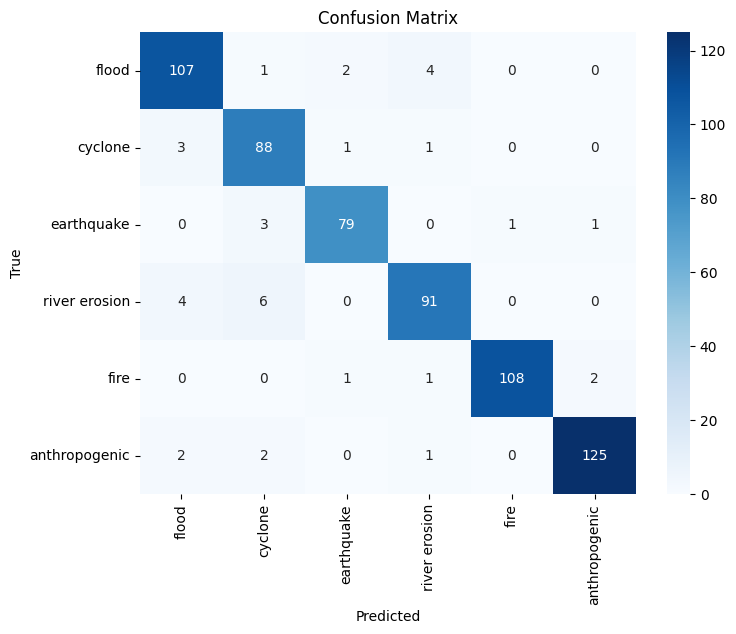

In [18]:
# Load best model and evaluate
model.load_state_dict(torch.load('best_model.pt'))
evaluate_model(model, test_loader)

In [19]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from sklearn.feature_extraction.text import CountVectorizer

bangla_stop_words = ['এবং', 'কিন্তু', 'যদি', 'এই', 'তারপর', 'জন্য', 'একটি', 'কোন', 'সাথে', 'হতে', 'বা', 'তাই', 'যখন', 'তাদের', 'অনেক', 'হয়', 'করেছে']
vectorizer = CountVectorizer(stop_words=bangla_stop_words, max_features=20)
X = vectorizer.fit_transform(df['caption'])
words = vectorizer.get_feature_names_out()
word_count = X.sum(axis=0).A1
word_freq = dict(zip(words, word_count))

# Use a font with Bangla and Latin support
font_path = "/usr/share/fonts/truetype/noto/NotoSans-Regular.ttf"
font_prop = fm.FontProperties(fname=font_path)

plt.figure(figsize=(12, 6))
plt.barh(list(word_freq.keys()), list(word_freq.values()), color='orange')
plt.xlabel('Frequency', fontsize=12)  # English - default font
plt.ylabel('Words (Bangla)', fontsize=12, fontproperties=font_prop)  # Bangla only
plt.title('🔹 Top 20 Frequent Words in Disaster-Related Bangla Text 🔹', fontsize=14, fontproperties=font_prop)  # Mix
plt.gca().invert_yaxis()
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['অন', 'একট', 'এব', 'কর', 'জন', 'যদ', 'রপর', 'হত', 'হয'] not in stop_words.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2437 (\N{BENGALI LETTER A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Matplotlib currently does not support Bengali natively.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2472 (\N{BENGALI LETTER NA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2438 (\N{BENGALI LETTER AA}) missing from current font.
  f

FileNotFoundError: [Errno 2] No such file or directory: '/usr/share/fonts/truetype/noto/NotoSans-Regular.ttf'

<Figure size 1200x600 with 1 Axes>